In [ ]:
# ! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/ && echo 'Done'

In [ ]:
!pip install Sastrawi

     |████████████████████████████████| 215kB 8.3MB/s 


In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Sastrawi
# import nltk
# from nltk.corpus import stopwords
# from  nltk.stem import SnowballStemmer
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# nltk.download('stopwords')
stopwords_factory = StopWordRemoverFactory()
stemmer_factory = StemmerFactory()

In [ ]:
# DATASET
# DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_COLUMNS=["target", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.95

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 15
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:
#!unzip "sentiment-analysis-dataset.zip" -d ""

In [ ]:
# df = pd.read_csv("Indonesian Sentiment Twitter Dataset Labeled.csv", encoding =DATASET_ENCODING , names=DATASET_COLUMNS, delimiter="\t", low_memory=False)
df = pd.read_csv("dataset_tweet_sentimen_all.csv", encoding = DATASET_ENCODING, names=DATASET_COLUMNS, delimiter=',', low_memory=False)
# df = pd.read_csv("v2_testSentimen.csv", encoding = DATASET_ENCODING, names=DATASET_COLUMNS, delimiter=',', low_memory=False, quotechar='|')
df = df.iloc[1:]

In [ ]:
print("Dataset size:", len(df))

Dataset size: 1800


In [ ]:
df.head()

,target,text
1,positive,"Undang @N_ShaniJKT48 ke hitamputih, pemenang S..."
2,positive,Selamat berbuka puasa Semoga amal ibadah hari ...
3,positive,"Ada nih di trans7 hitam putih, dia dpt penghar..."
4,positive,selamat ya mas @adietaufan masuk hitamputih
5,positive,Asiknya nonton Hitam Putih Trans7


In [ ]:
# decode_map = {0: "NEUTRAL", -1: "NEGATIVE", 1: "POSITIVE"}
# def decode_sentiment(label):
#     return decode_map[int(label)]

In [ ]:
# %%time
# df.target = df.target.apply(lambda x: decode_sentiment(x))

Text(0.5, 1.0, 'Dataset labels distribuition')

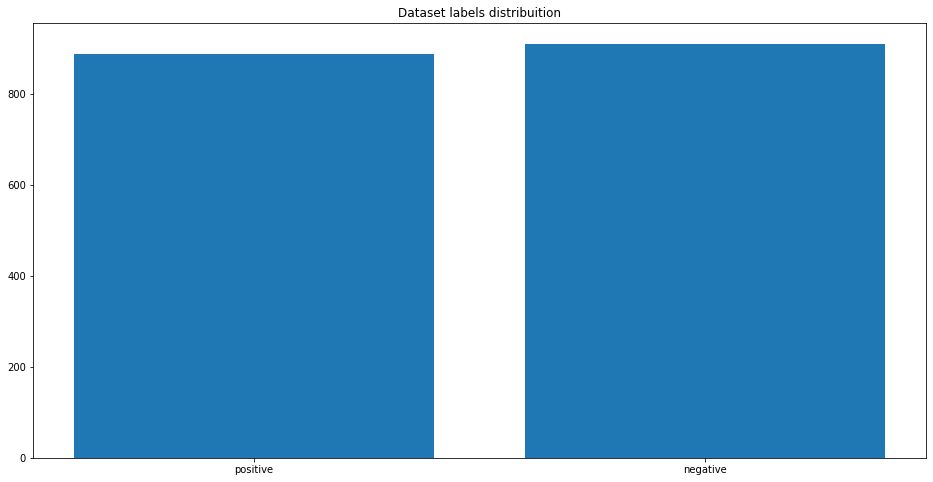

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
# stop_words = stopwords.words("english")
# stemmer = SnowballStemmer("english")
stop_words = stopwords_factory.get_stop_words()
stemmer = stemmer_factory.create_stemmer()

In [ ]:
# stop_words.append('AT_USER')
stop_words.append('<USER_MENTION>')
stop_words.append('URL')

In [ ]:
def preprocess(text, stem=False):
    #Convert to lower case
    text = text.lower()
    #Convert www.* or https?://* to URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',text)
    #Convert @username to AT_USER
    # text = re.sub('@[^\s]+','AT_USER',text)
    text = re.sub('@[^\s]+','<USER_MENTION>',text)
    #Remove additional white spaces
    text = re.sub('[\s]+', ' ', text)
    #Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1', text)
    #trim
    text = text.strip('\'"')
    return text

In [ ]:
#start getfeatureVector
def getFeatureVector(text):
    featureVector = []
    #split tweet into words
    words = text.split()
    for w in words:
        #replace two or more with two occurrences
        w = preprocess(w)
        #strip punctuation
        w = w.strip('\'"?,.')
        #check if the word stats with an alphabet
        val = re.search(r"^[a-zA-Z][a-zA-Z0-9]*$", w)
        #ignore if it is a stop word
        if(w in stop_words or val is None):
            continue
        else:
            featureVector.append(w.lower())
    return " ".join(featureVector)

In [ ]:
%%time
df.text = df.text.apply(lambda x: getFeatureVector(x))

CPU times: user 210 ms, sys: 0 ns, total: 210 ms
Wall time: 210 ms


In [ ]:
df.head(40)

,target,text
1,positive,undang hitamputih pemenang ssk jkt48 harusnya ...
2,positive,selamat berbuka puasa semoga amal ibadah hari ...
3,positive,nih trans7 hitam putih dpt penghargaan norwegi...
4,positive,selamat mas masuk hitamputih
5,positive,asiknya nonton hitam putih trans7
6,positive,acara paling komplit menarik hitam putih
7,positive,hitam putih t7 inspiratif banget
8,positive,suka banget acara hitam putih
9,positive,keren lu bro hitamputihtrans7
10,positive,tadi yg liat hitam putih trans7 ga sanggu ganteng


In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1709
TEST size: 91


In [ ]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.68 ms, sys: 1.12 ms, total: 3.8 ms
Wall time: 4.2 ms


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

2021-06-03 09:02:55,530 : INFO : collecting all words and their counts
2021-06-03 09:02:55,533 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-06-03 09:02:55,545 : INFO : collected 4871 word types from a corpus of 16299 raw words and 1709 sentences
2021-06-03 09:02:55,546 : INFO : Loading a fresh vocabulary
2021-06-03 09:02:55,554 : INFO : effective_min_count=10 retains 280 unique words (5% of original 4871, drops 4591)
2021-06-03 09:02:55,555 : INFO : effective_min_count=10 leaves 7878 word corpus (48% of original 16299, drops 8421)
2021-06-03 09:02:55,558 : INFO : deleting the raw counts dictionary of 4871 items
2021-06-03 09:02:55,563 : INFO : sample=0.001 downsamples 109 most-common words
2021-06-03 09:02:55,566 : INFO : downsampling leaves estimated 5273 word corpus (66.9% of prior 7878)
2021-06-03 09:02:55,569 : INFO : estimated required memory for 280 words and 300 dimensions: 812000 bytes
2021-06-03 09:02:55,571 : INFO : resetting layer weights


In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 4872
CPU times: user 30.3 ms, sys: 0 ns, total: 30.3 ms
Wall time: 30 ms


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 29 ms, sys: 2.78 ms, total: 31.8 ms
Wall time: 31.8 ms


In [ ]:
labels = df_train.target.unique().tolist()
# labels.append(NEUTRAL)
labels

['positive', 'negative']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)



y_train (1709, 1)
y_test (91, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1709, 300)
y_train (1709, 1)

x_test (91, 300)
y_test (91, 1)


In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(4872, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2021-06-03 09:03:09,004 : WARNING : Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          1461600   
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 1,622,101
Trainable params: 160,501
Non-trainable params: 1,461,600
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1)
                    # callbacks=callbacks)

Epoch 1/15
2/2 [==============================] - 29s 3s/step - loss: 0.6932 - accuracy: 0.5262 - val_loss: 0.6931 - val_accuracy: 0.5146
Epoch 2/15
2/2 [==============================] - 3s 1s/step - loss: 0.6931 - accuracy: 0.5015 - val_loss: 0.6932 - val_accuracy: 0.4854
Epoch 3/15
2/2 [==============================] - 3s 1s/step - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6934 - val_accuracy: 0.4854
Epoch 4/15
2/2 [==============================] - 3s 1s/step - loss: 0.6931 - accuracy: 0.5017 - val_loss: 0.6936 - val_accuracy: 0.4854
Epoch 5/15
2/2 [==============================] - 3s 1s/step - loss: 0.6930 - accuracy: 0.5050 - val_loss: 0.6937 - val_accuracy: 0.4854
Epoch 6/15
2/2 [==============================] - 3s 1s/step - loss: 0.6930 - accuracy: 0.5060 - val_loss: 0.6939 - val_accuracy: 0.4854
Epoch 7/15
2/2 [==============================] - 3s 1s/step - loss: 0.6929 - accuracy: 0.5108 - val_loss: 0.6940 - val_accuracy: 0.4854
Epoch 8/15
2/2 [========================

In [ ]:
 %%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

1/1 [==============================] - 0s 113ms/step - loss: 0.6913 - accuracy: 0.5385

ACCURACY: 0.5384615659713745
LOSS: 0.6912550330162048
CPU times: user 149 ms, sys: 536 µs, total: 150 ms
Wall time: 151 ms


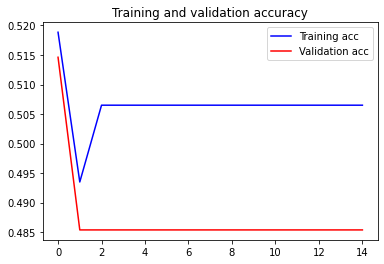

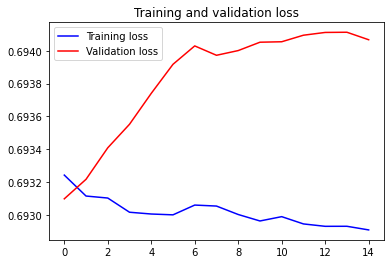

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    print(x_test)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("Barangnya jelek asli rugi banget", include_neutral=False)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0 

{'elapsed_time': 1.046149492263794,
 'label': 'NEGATIVE',
 'score': 0.4876819849014282}

In [ ]:
model.save("my_h5_bahasa_model.h5")

In [ ]:
import tensorflow as tf
from google.colab import drive
drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

In [ ]:
!ls /content/gdrive/MyDrive

In [ ]:

import os
save_path = os.path.join("/content/gdrive/MyDrive/coba/1")

In [ ]:
tf.keras.models.save_model(model, save_path)

In [ ]:
!ls /content/gdrive/MyDrive
